In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
import matplotlib.pyplot as plt 

In [2]:
# Loading the dataset
data = pd.read_csv("netflix_titles.csv")

data.dropna(subset=['cast','title','description','listed_in'],inplace=True,axis=0)
data = data.reset_index(drop=True)
data['listed_in'] = [re.sub(r'[^\w\s]', '', t) for t in data['listed_in']]
data['cast'] = [re.sub(',',' ',re.sub(' ','',t)) for t in data['cast']]
data['description'] = [re.sub(r'[^\w\s]', '', t) for t in data['description']]
data['title'] = [re.sub(r'[^\w\s]', '', t) for t in data['title']]
data["combined"] = data['listed_in'] + '  ' + data['cast'] + ' ' + data['title'] + ' ' + data['description']
data.drop(['listed_in','cast','description'],axis=1,inplace=True)

In [3]:
# Content Similarity
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(data["combined"])
cosine_similarities = linear_kernel(matrix, matrix)  # Calculate cosine similarities
movie_title = data['title']
indices = pd.Series(data.index, index=data['title'])
def content_recommender(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return movie_title.iloc[movie_indices]

In [4]:
# KNN Model
knn_data = matrix
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute')
knn_model.fit(knn_data)

def knn_recommender(title):
    idx = indices[title]
    distances, knn_indices = knn_model.kneighbors(knn_data[idx].reshape(1, -1), n_neighbors=5)
    similar_movies = [movie_title.iloc[i] for i in knn_indices[0]]
    return similar_movies

In [5]:
# Get content-based recommendations
content_recommendations = content_recommender('The Crown')
print("Content-Based Recommendations:")
print(content_recommendations)

Content-Based Recommendations:
709                                         Downton Abbey
543                                             The Queen
5283                          Witches A Century of Murder
6665                                           London Spy
6848                                       My Hotter Half
4797                                                Reign
7457      The Blue Planet A Natural History of the Oceans
7689                          The Real Football Factories
4528                                           Collateral
4625                                             Lovesick
7030                 Planet Earth The Complete Collection
5546                                         Age Gap Love
4566                          The Frankenstein Chronicles
3859                                 Single Ladies Senior
7458                                       The Bomb Squad
6879                         Natures Great Events Diaries
3888                                     

In [6]:
# Get KNN-based recommendations
knn_recommendations = knn_recommender('The Crown')
print("\nKNN-Based Recommendations:")
print(knn_recommendations)


KNN-Based Recommendations:
['The Crown', 'Downton Abbey', 'The Queen', 'Witches A Century of Murder', 'London Spy']


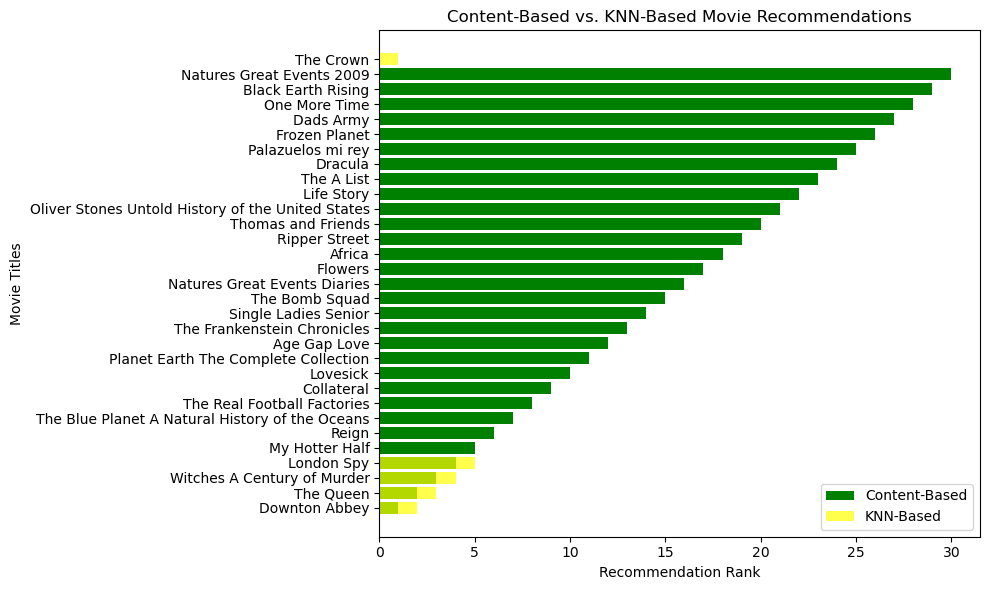

In [9]:
#Gaph to display recommendations
plt.figure(figsize=(10, 6))
plt.barh(content_recommendations, range(1, len(content_recommendations) + 1), label="Content-Based", color='green')
plt.barh(knn_recommendations, range(1, len(knn_recommendations) + 1), label="KNN-Based", color='yellow', alpha=0.7)
plt.xlabel("Recommendation Rank")
plt.ylabel("Movie Titles")
plt.title("Content-Based vs. KNN-Based Movie Recommendations")
plt.legend()
plt.tight_layout()
plt.show()